In [12]:
import pandas as pd
import numpy as np
import time
from uwbm_functions import *
from pandas import read_csv
import matplotlib.pyplot as plt

# =============================================================================
# Input

# City case
city = 'Paramaribo'
# Rainfall & evaporation timeseries
input_csv = 'input_9yr_hourly_draft_incl_evap_daily_data.csv'
# .csv with the parameters for the measures (this file needs to be called exactly: Parameters measures.csv)
measures = pd.read_csv('../input/Parameters measures.csv', index_col=0)
# .xlsx with the parameters for the measures which are implemented by adjusting the catchment properties
measures_exception = pd.read_excel('../input/Parameters measures exception_quicktest.xlsx', sheet_name=None)
# .csv with the parameters for the neighbourhood types (this file needs to be called exactly: Parameters neighbourhoods.csv)
# (= possibilty to add different neighbourhoods, unlimited nr)
neighbourhood_pars = pd.read_csv('../input/Parameters neighbourhoods.csv')
# =============================================================================

# Create a list will all measures: '.csv measures' and the exceptions
total_measures = list(measures.index)
total_measures_titles = list(measures['title'])
for i in measures_exception:
    total_measures.append(measures_exception[i]['id'][0])
    total_measures_titles.append(measures_exception[i]['title'][0])

# Create DataFrames to store the results in
df = pd.DataFrame(columns=['id', 'Measure', '0', '5', '10', '20', '30', '40', '50', '100'])
df['id'] = total_measures
df['Measure'] = total_measures_titles
df['0'] = np.zeros(len(df.index))

df_runoff = df.copy()
df_Ftot = df.copy()
df_gw = df.copy()
df_evap = df.copy()
df_gw.insert(2, 'Baseline', np.zeros(len(df_gw.index)))
df_evap.insert(2, 'Baseline', np.zeros(len(df_evap.index)))



# Add measures that only have zeros (no hydrological effect)    
measures_zeros = {
'id': [7,8,13,14,57,61,62,80,81,83,84,86,87,88,89,35],
'Measure': ['Fonteinen, watervallen en watermuren', 'Cooling with water elements: ponds',
            'Floating  puri-plants (floatlands)', 'Groene gevels', 'Slim beregeningsbeleid/smart irrigation',
            'Wetting surfaces (of gardens, roofs, roads)', 'Koele materialen (hoge albedo)', 'Creeren van schaduw',
            'Dijken', 'Kades (lage dijkjes)', 'Droogtebestendige planten en bomen', 'Superdijk (komt te vervallen)',
            'Kademuur', 'Gebouw als waterkering', 'Tijdelijke kering', 'Surface drains']}
df_measures_zeros = pd.DataFrame(data=measures_zeros)

df_runoff = pd.concat([df_runoff, df_measures_zeros])
df_runoff = df_runoff.fillna(0)
df_Ftot = pd.concat([df_Ftot, df_measures_zeros])
df_Ftot = df_Ftot.fillna(0)
df_gw = pd.concat([df_gw, df_measures_zeros])
df_gw = df_gw.fillna(0)
df_evap = pd.concat([df_evap, df_measures_zeros])
df_evap = df_evap.fillna(0)




# The following notes the time, which is used to calculate the remaining runtime of the script
time_counter = 0
max_time_counter = len(neighbourhood_pars) * len(total_measures)
start_time = time.time()



print('Total number of neighborhoods to run: ', len(neighbourhood_pars))

# Loop for each neighbourhood type in the 'Parameters neighbourhoods' file
for n in range(len(neighbourhood_pars)):
    
    title_name = neighbourhood_pars['title'][n]
    
    # Catchment properties .ini file for the initial parameters
    catchment_properties = f'ep_neighbourhood_{city}_{title_name}.ini'
    # Output file name (.xlsx (defined at bottom) gets added to it in the script, so this should be left out here)
    output_name = f'measures_output_{city}_{title_name}'
    
    
    print('\n')
    neighbourhood_id = neighbourhood_pars['id_type'][n]
    
    # Base run: run the model without any measure implemented yet. This is needed to do a comparison between base and measure run.
    print('Currently running Neighbourhood ' + str(n+1) + ' - Base run')
    inputdata = read_inputdata(input_csv)
    dict_param = read_parameters_csv(catchment_properties, str(measures.index[0]), neighbourhood_id, apply_measure=False)
    if dict_param ['tot_up_area'] == 0 and np.any(measures['up_meas_area'] == 1):
        print ('error: measure' +str(measures[measures['up_meas_area'] == 1].title.values) + 'cannot be applied in zero sized unpaved area!')
        break
    if dict_param ['tot_cp_area'] == 0 and np.any(measures['cp_meas_area'] == 1):
        print ('error: measure ' +str(measures[measures['cp_meas_area'] == 1].title.values) + 'cannot be applied in zero sized closed paved area!')
        break
    if dict_param ['tot_op_area'] == 0 and np.any(measures['op_meas_area'] == 1):
        print ('error: measure' + str(measures[measures['op_meas_area'] == 1].title.values) + 'cannot be applied in zero sized open paved area!')
        break
    if dict_param ['tot_pr_area'] == 0 and np.any(measures['pr_meas_area'] == 1):
        print ('error: measure ' + str(measures[measures['pr_meas_area'] == 1].title.values) + 'cannot be applied in zero sized paved roof area!')
        break
    base_run = running(inputdata, dict_param)
    
    # Calculate amount of paved- and unpaved area, required for the Ftot calculation
    Ap = dict_param['tot_pr_area'] + dict_param['tot_cp_area'] + dict_param['tot_op_area']
    Aup = dict_param['tot_up_area']
    
    # Fraction of runoff from unpaved compared to paved, required for the Ftot calculation.
    # This needs adjustments as the runoff sum difference may not be a good indication for the difference in peak runoff
    sum_Rp = base_run[0]['r_cp_meas'].sum() + base_run[0]['r_cp_swds'].sum() + base_run[0]['r_cp_mss'].sum() + base_run[0]['r_cp_up'].sum()
    sum_Rup = base_run[0]['r_up_ow'].sum() + base_run[0]['r_up_meas'].sum()
    frac_Rup_Rp = sum_Rup / sum_Rp
    
    # Loop for each measure in the 'Parameters measures' file
    for i in measures.index:
        measure_id = str(i)
    
        # Calculate depth measure based on the inflow factor and the effective depth. Currently, the default values for inflow factor are used.
        D_eff = [5, 10, 20, 30, 40, 50, 100]
        inflow_factor = measures['Ain_def'][i]
        D_meas = [x * inflow_factor for x in D_eff]
        
        # Measures with an base storage, such as wet ponds, should have the extra depth added to this base storage.
        if measures['stor_btm_meas_t0'][i] > 0:
            D_meas = [x * inflow_factor + measures['stor_btm_meas_t0'][i] for x in D_eff]
        
        # Determine the storage capacity parameter which needs to be changed depending on the amount of storage layers in the measure.
        # Green roofs (extensive) consists of three layers, however, are an exception where the top layer storage needs to be adjusted instead of the bottom layer storage.
        if int(measures['num_stor_lvl'][i]) == 1:
            varkey = 'storcap_int_meas'
        elif measure_id in ['15', '16']:
            varkey = 'storcap_top_meas'
        elif int(measures['num_stor_lvl'][i]) > 1:
            varkey = 'storcap_btm_meas'
    
        # Determine the runoff variable which acts as a baseline. This is based on the source of the inflow for the measure: pr, cp, op, up, ow.
        if measures['pr_meas_inflow_area'][i] > 0:
            baseline_variable = 'r_pr_swds'
            Ami = dict_param['tot_pr_area']
        elif measures['cp_meas_inflow_area'][i] > 0:
            baseline_variable = 'r_cp_swds'
            Ami = dict_param['tot_cp_area']
        elif measures['op_meas_inflow_area'][i] > 0:
            baseline_variable = 'r_op_swds'
            Ami = dict_param['tot_op_area']
        elif measures['up_meas_inflow_area'][i] > 0:
            baseline_variable = 'r_up_ow'
            Ami = dict_param['tot_up_area']
        elif measures['ow_meas_inflow_area'][i] > 0:
            baseline_variable = 'r_ow_swds'
            Ami = dict_param['tot_ow_area']
        
        # Determine variable_to_save for runoff based on the area where the uncontrolled runoff is discharged to
        if measures['surf_runoff_meas_OW'][i] == 1:
            variable_to_save = 'q_meas_ow'
        elif measures['surf_runoff_meas_UZ'][i] == 1:
            variable_to_save = 'q_meas_uz'
        elif measures['surf_runoff_meas_GW'][i] == 1:
            variable_to_save = 'q_meas_gw'
        elif measures['surf_runoff_meas_SWDS'][i] == 1:
            variable_to_save = 'q_meas_swds'
        elif measures['surf_runoff_meas_MSS'][i] == 1:
            variable_to_save = 'q_meas_mss'
        elif measures['surf_runoff_meas_Out'][i] == 1:
            variable_to_save = 'q_meas_out'
        
        # Runoffcap_stor_dependent checks whether the runoff capacity of the measure depends on the storage capacity, e.g. in an underground storage or rain barrel
        if measures.loc[i]['runoffcap_stor_dependent'] == 1:
            runoffcap_factor = measures.loc[i]['runoffcap_stor_factor']
            runoffcap_meas = [x * runoffcap_factor for x in D_meas]
            runoff, gw, evap = run_measures(input_csv, catchment_properties, measure_id, neighbourhood_id, output_name, base_run, varkey = varkey, vararrlist1 = D_meas, correspvarkey='runoffcap_btm_meas', vararrlist2=runoffcap_meas, baseline_variable=baseline_variable, variable_to_save=variable_to_save)
        else:
            runoff, gw, evap = run_measures(input_csv, catchment_properties, measure_id, neighbourhood_id, output_name, base_run, varkey = varkey, vararrlist1 = D_meas, correspvarkey=None, vararrlist2=None, baseline_variable=baseline_variable, variable_to_save=variable_to_save)
        
        num_years = (pd.to_datetime(runoff.Date[len(runoff.Date)-1]) - pd.to_datetime(runoff.Date[0])).days / 365
        num_years = round(num_years)
        
        # 'getconstants_measures' calculates the runoff reduction factors for the measures at each effective depth   
        constants_runoff, mean_constants_runoff = getconstants_measures(runoff, num_year=num_years)
        gw = round(gw / num_years, 2)
        evap = round(evap / num_years, 2)
        
        idx_measure = np.where(df_runoff.id==i)[0][0]
        df_runoff.loc[idx_measure, ['5', '10', '20', '30', '40', '50', '100']] = mean_constants_runoff
        df_gw.loc[idx_measure, ['Baseline', '5', '10', '20', '30', '40', '50', '100']] = gw.values[0]
        df_gw.loc[idx_measure, ['5', '10', '20', '30', '40', '50', '100']] -= gw['Baseline'].values[0]
        df_evap.loc[idx_measure, ['Baseline', '5', '10', '20', '30', '40', '50', '100']] = evap.values[0]
        df_evap.loc[idx_measure, ['5', '10', '20', '30', '40', '50', '100']] -= evap['Baseline'].values[0]
        
        # =============================================================================
        #     Calculate Ftot: Runoff reduction factor over the total area
        # =============================================================================
        
        # Calculate the Ftot according to the inflow area of the measure, assuming no measures are taken on unpaved or open water
        Fmeas = mean_constants_runoff
        df_Ftot.loc[idx_measure, ['5', '10', '20', '30', '40', '50', '100']] = np.round( ( Ap * np.exp(Ami*np.log(Fmeas)/Ap) + frac_Rup_Rp * Aup ) / ( Ap + frac_Rup_Rp * Aup ), 2)
        
        # Calculate the remaining runtime of the script
        end_time = time.time()
        runtime = end_time - start_time
        time_counter += 1
        fraction = time_counter / max_time_counter
        timeleft = round(((1/fraction) - 1) * runtime / 60,1)
        print(str(timeleft) + ' minutes remaining')
    
    # Loop for the exception measures, which are implemented by altering the catchment itself, rather than implemented as a separate measure.
    for title in measures_exception:
        measure_title = title
        
        baseline_variable = measures_exception[measure_title]['baseline_variable'][0]
        variable_to_save = measures_exception[measure_title]['variable_to_save'][0]
        
        runoff, gw, evap = run_measures_exception(input_csv, catchment_properties, measure_title, neighbourhood_id, base_run, baseline_variable, variable_to_save)
        
        num_years = (pd.to_datetime(runoff.Date[len(runoff.Date)-1]) - pd.to_datetime(runoff.Date[0])).days / 365
        num_years = round(num_years)
        
        constants_runoff, mean_constants_runoff = getconstants_measures(runoff, num_year=num_years)
        gw = round(gw / num_years, 2)
        evap = round(evap / num_years, 2)
        
        idx_measure = np.where(df_runoff.id == measures_exception[measure_title]['id'][0])[0][0]
        df_runoff.loc[idx_measure, ['5', '10', '20', '30', '40', '50', '100']] = mean_constants_runoff[0]
        
        df_gw.loc[idx_measure, 'Baseline'] = gw['Baseline'].values[0]
        df_gw.loc[idx_measure, ['5', '10', '20', '30', '40', '50', '100']] = gw['alt'].values[0]
        
        df_evap.loc[idx_measure, 'Baseline'] = evap['Baseline'].values[0]
        df_evap.loc[idx_measure, ['5', '10', '20', '30', '40', '50', '100']] = evap['alt'].values[0]        
        
        # Calculate Ftot
        Fmeas = mean_constants_runoff[0]
        Inflow_area = measures_exception[measure_title]['inflow_area'][0]
        Ami = dict_param[f'tot_{Inflow_area}_area']
        df_Ftot.loc[idx_measure, ['5', '10', '20', '30', '40', '50', '100']] = np.round( ( Ap * np.exp(Ami*np.log(Fmeas)/Ap) + frac_Rup_Rp * Aup ) / ( Ap + frac_Rup_Rp * Aup ), 2)

        
    # Add '1000' mm effective depth column
    df_runoff['1000'] = df_runoff['100']
    df_Ftot['1000'] = df_Ftot['100']
    df_gw['1000'] = df_gw['100']
    df_evap['1000'] = df_evap['100']
    
    
    
    # changing baseline columns for selected measures
    df_change_list = [df_gw, df_evap]
    for df_i in df_change_list:
        df_i['5'] = np.where(df_i['id'].isin([3,19,25,26,32,39,51,91,94]), df_i['5'] - df_i['Baseline'], df_i['5'])
        df_i['10'] = np.where(df_i['id'].isin([3,19,25,26,32,39,51,91,94]), df_i['10'] - df_i['Baseline'], df_i['10'])
        df_i['20'] = np.where(df_i['id'].isin([3,19,25,26,32,39,51,91,94]), df_i['20'] - df_i['Baseline'], df_i['20'])
        df_i['30'] = np.where(df_i['id'].isin([3,19,25,26,32,39,51,91,94]), df_i['30'] - df_i['Baseline'], df_i['30'])
        df_i['40'] = np.where(df_i['id'].isin([3,19,25,26,32,39,51,91,94]), df_i['40'] - df_i['Baseline'], df_i['40'])
        df_i['50'] = np.where(df_i['id'].isin([3,19,25,26,32,39,51,91,94]), df_i['50'] - df_i['Baseline'], df_i['50'])
        df_i['100'] = np.where(df_i['id'].isin([3,19,25,26,32,39,51,91,94]), df_i['100'] - df_i['Baseline'], df_i['100'])
        df_i['1000'] = np.where(df_i['id'].isin([3,19,25,26,32,39,51,91,94]), df_i['1000'] - df_i['Baseline'], df_i['1000'])

    
    # Sort the values on measure id
    df_runoff = df_runoff.sort_values(by='id').reset_index(drop=True)
    df_Ftot   = df_Ftot.sort_values(by='id').reset_index(drop=True)
    df_gw     = df_gw.sort_values(by='id').reset_index(drop=True)
    df_evap   = df_evap.sort_values(by='id').reset_index(drop=True)    
    
    
    neighbourhood_name = neighbourhood_pars['title'][n]
    output_file = output_name + ' - %s.xlsx' % neighbourhood_name
    
    # Save the results in a .xsls (Excel workbook) file
    with pd.ExcelWriter('pysol/' + output_file) as writer:
        df_runoff.to_excel(writer, sheet_name='Runoff factor', index=0)
        df_Ftot.to_excel(writer, sheet_name='Ftot', index=0)
        df_gw.to_excel(writer, sheet_name='Groundwater recharge', index=0)
        df_evap.to_excel(writer, sheet_name='Evaporation', index=0)
    
    
    # Save the results to json file
    #without baseline:
    df_lib_1 = {'ast_measures_pluvflood': df_runoff, 'ast_measures_Ftot': df_Ftot}
    #with baseline:
    df_lib_2 = {'ast_measures_groundwater_recharge': df_gw, 'ast_measures_evapotranspiration': df_evap}


    for df_i in df_lib_1:
        json_df = df_lib_1[df_i].rename(columns={"id": "ID", "Measure": "name", "0": "Col0", 
                                        "5": "Col1", "10": "Col2", "20": "Col3",
                                        "30": "Col4", "40": "Col5", "50": "Col6",
                                        "100": "Col7", "1000": "Col8"}, errors='ignore')
        json_df = json_df.drop(columns=['Baseline'], errors='ignore')
        json_df.to_json('pysol/' + f'{df_i}' + f'_{title_name}.json', orient='records', indent=4)




    for df_i in df_lib_2:
        json_df = df_lib_2[df_i].rename(columns={"id": "ID", "Measure": "name", "Baseline": "Col0", "0": "Col1", 
                                        "5": "Col2", "10": "Col3", "20": "Col4",
                                        "30": "Col5", "40": "Col6", "50": "Col7",
                                        "100": "Col8", "1000": "Col9"}, errors='ignore')
        json_df.to_json('pysol/' + f'{df_i}' + f'_{title_name}.json', orient='records', indent=4)

Total number of neighborhoods to run:  3


Currently running Neighbourhood 1 - Base run


C:\Users\rooze_dn\Documents\UWBM-input\REACHOUT\Model run\uwbm_functions.py:1099: RuntimeWarning: invalid value encountered in scalar divide
  e_meas = sum_evap_meas * dict_param["tot_area"] / dict_param["tot_meas_area"]
C:\Users\rooze_dn\Documents\UWBM-input\REACHOUT\Model run\uwbm_functions.py:1100: RuntimeWarning: invalid value encountered in scalar divide
  ds_meas = sum_ds_meas * dict_param["tot_area"] / dict_param["tot_meas_area"]


Currently running Neighbourhood 1 - Urban wetland
Elapsed: 15.56s


C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


5.0 minutes remaining
Currently running Neighbourhood 1 - Bioswale
Elapsed: 15.56s


C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4.5 minutes remaining
Currently running Neighbourhood 1 - Deep groundwater infiltration
Elapsed: 14.86s


C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4.1 minutes remaining
Currently running Neighbourhood 1 - Ditches
Elapsed: 15.18s


C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3.8 minutes remaining
Currently running Neighbourhood 1 - Intensive green roofs
Elapsed: 14.41s


C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3.5 minutes remaining
Currently running Neighbourhood 1 - Adding trees to streetscape


C:\Users\rooze_dn\Documents\UWBM-input\REACHOUT\Model run\uwbm_functions.py:1099: RuntimeWarning: invalid value encountered in scalar divide
  e_meas = sum_evap_meas * dict_param["tot_area"] / dict_param["tot_meas_area"]
C:\Users\rooze_dn\Documents\UWBM-input\REACHOUT\Model run\uwbm_functions.py:1100: RuntimeWarning: invalid value encountered in scalar divide
  ds_meas = sum_ds_meas * dict_param["tot_area"] / dict_param["tot_meas_area"]
C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)




Currently running Neighbourhood 2 - Base run


C:\Users\rooze_dn\Documents\UWBM-input\REACHOUT\Model run\uwbm_functions.py:1099: RuntimeWarning: invalid value encountered in scalar divide
  e_meas = sum_evap_meas * dict_param["tot_area"] / dict_param["tot_meas_area"]
C:\Users\rooze_dn\Documents\UWBM-input\REACHOUT\Model run\uwbm_functions.py:1100: RuntimeWarning: invalid value encountered in scalar divide
  ds_meas = sum_ds_meas * dict_param["tot_area"] / dict_param["tot_meas_area"]


Currently running Neighbourhood 2 - Urban wetland
Elapsed: 13.72s


C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3.2 minutes remaining
Currently running Neighbourhood 2 - Bioswale
Elapsed: 13.78s


C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2.9 minutes remaining
Currently running Neighbourhood 2 - Deep groundwater infiltration
Elapsed: 13.32s


C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2.6 minutes remaining
Currently running Neighbourhood 2 - Ditches
Elapsed: 13.02s


C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2.3 minutes remaining
Currently running Neighbourhood 2 - Intensive green roofs
Elapsed: 12.94s


C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2.0 minutes remaining
Currently running Neighbourhood 2 - Adding trees to streetscape


C:\Users\rooze_dn\Documents\UWBM-input\REACHOUT\Model run\uwbm_functions.py:1099: RuntimeWarning: invalid value encountered in scalar divide
  e_meas = sum_evap_meas * dict_param["tot_area"] / dict_param["tot_meas_area"]
C:\Users\rooze_dn\Documents\UWBM-input\REACHOUT\Model run\uwbm_functions.py:1100: RuntimeWarning: invalid value encountered in scalar divide
  ds_meas = sum_ds_meas * dict_param["tot_area"] / dict_param["tot_meas_area"]
C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)




Currently running Neighbourhood 3 - Base run


C:\Users\rooze_dn\Documents\UWBM-input\REACHOUT\Model run\uwbm_functions.py:1099: RuntimeWarning: invalid value encountered in scalar divide
  e_meas = sum_evap_meas * dict_param["tot_area"] / dict_param["tot_meas_area"]
C:\Users\rooze_dn\Documents\UWBM-input\REACHOUT\Model run\uwbm_functions.py:1100: RuntimeWarning: invalid value encountered in scalar divide
  ds_meas = sum_ds_meas * dict_param["tot_area"] / dict_param["tot_meas_area"]


Currently running Neighbourhood 3 - Urban wetland
Elapsed: 13.68s


C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1.8 minutes remaining
Currently running Neighbourhood 3 - Bioswale
Elapsed: 13.98s


C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1.5 minutes remaining
Currently running Neighbourhood 3 - Deep groundwater infiltration
Elapsed: 13.00s


C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1.3 minutes remaining
Currently running Neighbourhood 3 - Ditches
Elapsed: 13.29s


C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1.0 minutes remaining
Currently running Neighbourhood 3 - Intensive green roofs
Elapsed: 12.72s


C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.7 minutes remaining
Currently running Neighbourhood 3 - Adding trees to streetscape


C:\Users\rooze_dn\Documents\UWBM-input\REACHOUT\Model run\uwbm_functions.py:1099: RuntimeWarning: invalid value encountered in scalar divide
  e_meas = sum_evap_meas * dict_param["tot_area"] / dict_param["tot_meas_area"]
C:\Users\rooze_dn\Documents\UWBM-input\REACHOUT\Model run\uwbm_functions.py:1100: RuntimeWarning: invalid value encountered in scalar divide
  ds_meas = sum_ds_meas * dict_param["tot_area"] / dict_param["tot_meas_area"]
C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rooze_dn\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<AxesSubplot:>

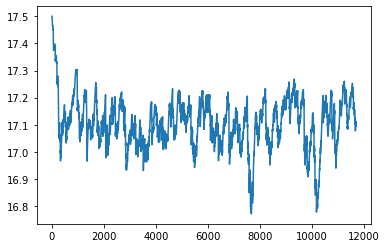

In [19]:
base_run[0]['gwl'].plot()

In [8]:
df_measures_zeros

,id,Measure
0,7,"Fonteinen, watervallen en watermuren"
1,8,Cooling with water elements: ponds
2,13,Floating puri-plants (floatlands)
3,14,Groene gevels
4,57,Slim beregeningsbeleid/smart irrigation
5,61,"Wetting surfaces (of gardens, roofs, roads)"
6,62,Koele materialen (hoge albedo)
7,80,Creeren van schaduw
8,81,Dijken
9,83,Kades (lage dijkjes)
